In [1]:
import pandas as pd
import numpy as np
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, RNN, Lambda, Concatenate, Reshape
from keras.layers.merge import Multiply
from keras.models import Model
from keras.losses import mean_squared_error, binary_crossentropy
from keras.models import Model
from keras.models import load_model
from keras.models import model_from_json
import keras.backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

Using TensorFlow backend.


In [2]:
def open_and_load(string):
    with open('trained/'+string+'.json', 'r') as f:
        model = model_from_json(f.read())
    model.load_weights('trained/'+string+'.h5')   
    return model

In [3]:
model_ws = open_and_load('model_ws') #straight movement
model_b = open_and_load('model_b') #bounces
model_att = open_and_load('model_att')
model_lambda = open_and_load('model_lambda')

In [4]:
isBounce = K.tf.convert_to_tensor([0,1],dtype=np.float32) #if attention outputs this, then bounce module is needed

inputs_rec = Input(shape=(4,1), name='input_rec')
rec = model_ws(inputs_rec)
rec_x = Lambda(lambda s: K.reshape(s[:,0], (-1,1)))(rec)
bnc = model_b(rec)
att = model_lambda(rec_x)
att2 = Lambda(lambda s: K.switch(K.equal(s[0], isBounce), s[1], s[2]))([att, bnc, rec]) #~hard attention

x = att2

model_m = Model(inputs=inputs_rec, outputs=x)
model_m.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])
model_m.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_rec (InputLayer)          (None, 4, 1)         0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 2)            106         input_rec[0][0]                  
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_1[1][0]                    
__________________________________________________________________________________________________
model_5 (Model)                 (None, 2)            238         lambda_1[0][0]                   
__________________________________________________________________________________________________
model_3 (M

In [5]:
df = pd.read_csv('data/bounces_2d.csv')
a = df.to_numpy()
a = a.reshape((1000,5,4))
X = a[:,:4,0].reshape(1000,4,1) #np.delete(a, [1,3], axis=2)[:,:10,:]
Y = a[:,4,:2] #.reshape(10000,5,2)
train_X = X[:800]
train_Y = Y[:800]
test_X = X[800:]
test_Y = Y[800:]

df2 = pd.read_csv('data/sim_data_borders.csv')
# x, x_vel, y, y_vel
a2 = df2.to_numpy()
a2 = a2.reshape((4000,5,4)) #samples x timesteps x features
X2 = a2[:,:4,0].reshape(4000,4,1) #np.delete(a, [1,3], axis=2)[:,:10,:]
Y2 = a2[:,4,:2] #.reshape(10000,5,2)
train_X2 = X2[:8000]
train_Y2 = Y2[:8000]

mixdf = pd.concat([df, df2[:5000]])
mix = mixdf.to_numpy()
mix = mix.reshape(2000,5,4)
np.random.shuffle(mix)
mix_train_x = mix[:1800,:4,0].reshape(1800,4,1)
mix_train_y = mix[:1800,4,:2]
mix_test_x = mix[1800:,:4,0].reshape(200,4,1)
mix_test_y = mix[1800:,4,:2]
print("Root mean squared error: %.4f" % mse(model_m.predict(train_X2), train_Y2)**0.5)

Root mean squared error: 0.0163


In [6]:
model_m.predict(train_X[:10])

array([[ 0.40100327,  0.06981026],
       [ 0.7727631 ,  0.08543855],
       [ 0.9824763 , -0.04799932],
       [ 0.66460073,  0.07897948],
       [ 0.9990897 , -0.00986722],
       [ 0.69635075,  0.04131683],
       [ 0.49376938,  0.07037897],
       [ 0.99647456, -0.03402132],
       [ 0.9805412 , -0.07780412],
       [ 0.31318933,  0.0346712 ]], dtype=float32)

In [7]:
train_X[:10]

array([[[0.12009377],
        [0.19001882],
        [0.25994387],
        [0.32986892]],

       [[0.43012772],
        [0.51582197],
        [0.60151622],
        [0.68721048]],

       [[0.82844169],
        [0.87551171],
        [0.92258172],
        [0.96965174]],

       [[0.34745762],
        [0.42674826],
        [0.50603891],
        [0.58532955]],

       [[0.96469246],
        [0.97366296],
        [0.98263347],
        [0.99160398]],

       [[0.53348851],
        [0.57410824],
        [0.61472797],
        [0.6553477 ]],

       [[0.21052448],
        [0.28119206],
        [0.35185965],
        [0.42252723]],

       [[0.87044603],
        [0.9035191 ],
        [0.93659217],
        [0.96966524]],

       [[0.70945743],
        [0.78681165],
        [0.86416588],
        [0.9415201 ]],

       [[0.1746778 ],
        [0.2091779 ],
        [0.24367801],
        [0.27817812]]])

# 2D

In [65]:
inputs = Input(shape=(4,2))

split_x = Lambda(lambda s: s[:,:,0], output_shape=(4,1))(inputs)
split_x = Reshape((4,1))(split_x) #split_x.shape gives (None, 4) otherwise
model_x = model_m(split_x)

split_y = Lambda(lambda s: s[:,:,1], output_shape=(4,1))(inputs)
split_y = Reshape((4,1))(split_y)
model_y = model_m(split_y)

x = Concatenate()([model_x, model_y])

model_2d = Model(inputs=inputs, outputs=x)
model_2d.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])
model_2d.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 4, 2)         0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 4, 1)         0           input_2[0][0]                    
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 4, 1)         0           input_2[0][0]                    
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 4, 1)         0           lambda_5[0][0]                   
__________________________________________________________________________________________________
reshape_4 

In [66]:
df[10:21]

,x,x_vel,y,y_vel
10,0.828442,0.047070,0.923224,-0.099696
11,0.875512,0.047070,0.823528,-0.099696
12,0.922582,0.047070,0.723832,-0.099696
13,0.969652,0.047070,0.624137,-0.099696
14,0.983278,-0.047070,0.524441,-0.099696
15,0.347458,0.079291,0.323473,-0.095410
16,0.426748,0.079291,0.228063,-0.095410
17,0.506039,0.079291,0.132653,-0.095410
18,0.585330,0.079291,0.037243,-0.095410
19,0.664620,0.079291,0.058167,0.095410


In [67]:
a = df.to_numpy()
a = a.reshape((1000,5,4))
X = a[:,:4,[0,2]].reshape(1000,4,2) #np.delete(a, [1,3], axis=2)[:,:10,:]
Y = a[:,4,:] #.reshape(10000,5,2)
train_X = X[:800]
train_Y = Y[:800]
test_X = X[800:]
test_Y = Y[800:]

In [11]:
#train_Y[:10]
#model_2d.predict(train_X[:10])

In [12]:
mixdf = pd.concat([df, df2[:5000]])
mix = mixdf.to_numpy()
mix = mix.reshape(2000,5,4)
np.random.shuffle(mix)
mix_train_x = mix[:1800,:4,0].reshape(1800,4,1)
mix_train_y = mix[:1800,4,:2]
mix_test_x = mix[1800:,:4,0].reshape(200,4,1)
mix_test_y = mix[1800:,4,:2]
mse(mix_test_y, model_m.predict(mix_test_x))**0.5 # My model

0.016953466437487644

In [74]:
np.arange(10)[-4:]

array([6, 7, 8, 9])

In [13]:
%matplotlib notebook

In [250]:
a = train_X[3]
a = a.reshape(1,4,2)

<IPython.core.display.Javascript object>


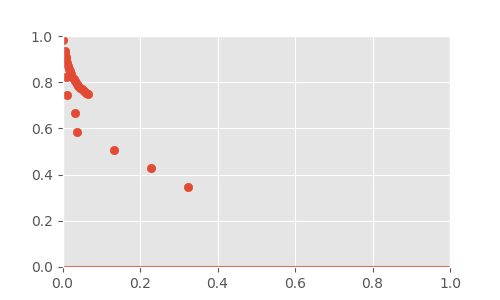

In [251]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def make_preds(a, model):
    #Predicting
    b = a.tolist()
    tmp = np.copy(a)
    for i in range(100):
        preds = model.predict(tmp)[:,[0,2]]
        b[0] += preds.tolist()
        tmp = np.append(tmp, preds.reshape(1,1,2), axis=1)
        tmp = tmp[:,1:]
    b = np.array(b)
    return b

b = make_preds(a, model_2d)
#Plotting
fig, ax = plt.subplots(figsize=(5, 3))
ax.set(xlim=(0, 1), ylim=(0, 1))
line = ax.plot([0,1],[0,0])

#     def animate(i):
#         line.set_ydata(b[0,:i,1])
#         line.set_xdata(b[0,:i,0])

scat = ax.scatter( b[0,:2,1],  b[0,:2,0])

def animate(i):
    # Must pass scat.set_offsets an N x 2 array
    t = np.array([b[0,:i,1], b[0,:i,0]])
    scat.set_offsets(t.T)

anim = FuncAnimation(
    fig, animate, interval=500, frames=100, repeat=False)

plt.draw()
plt.show()